In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar

from sklearn.linear_model import LinearRegression


In [2]:
homicidio_hecho = pd.read_csv("./Datasets/homicidio_hecho.csv", sep = "|", encoding = "utf-8")
homicidio_vict = pd.read_csv("./Datasets/homicidio_vict.csv", sep = "|", encoding = "utf-8")

**Analisis por tipo de vehiculo**

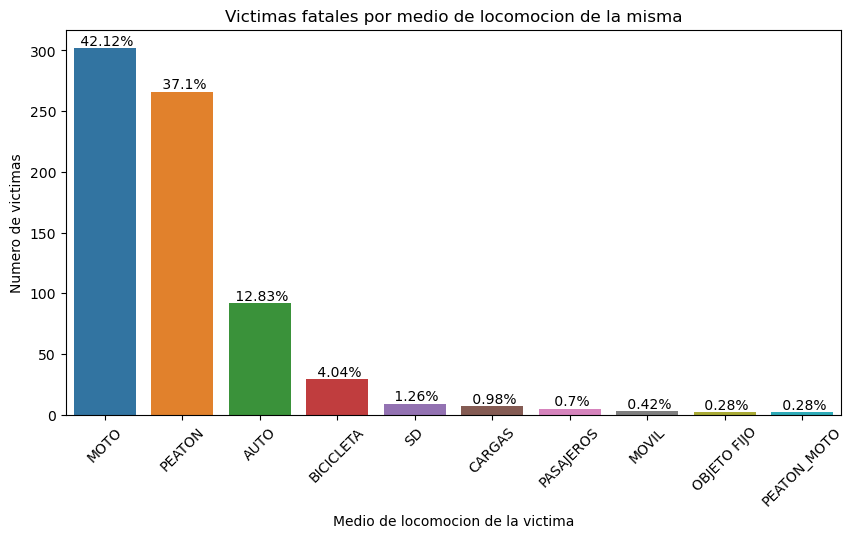

In [3]:
# Victimas totales por tipo de vehiculo de la victima
events_by_victim = homicidio_hecho.groupby('victima')['num_victimas'].sum().reset_index(name = 'num_victimas')
events_by_victim.sort_values(by = 'num_victimas', axis = 0, ascending = False, inplace = True)
victimas_totales = events_by_victim.num_victimas.sum()
events_by_victim['porcentaje'] = round(100 * events_by_victim['num_victimas'] / victimas_totales, 2)

plt.figure(figsize = (10,5))
ax = sns.barplot(x = 'victima', y = 'num_victimas', data = events_by_victim, 
                 order = events_by_victim.sort_values('num_victimas', ascending = False).victima)

labels = [f' {events_by_victim.iloc[i, 2]}%' for i, v in enumerate(ax.containers[0])]
ax.bar_label(ax.containers[0], labels = labels)
for item in ax.get_xticklabels(): item.set_rotation(45)
plt.title('Victimas fatales por medio de locomocion de la misma')
plt.xlabel('Medio de locomocion de la victima')
plt.ylabel('Numero de victimas')

plt.show()
# donde se puede observar que las victimas son principalmente peatones y conductores de motos,
# mientras que en tercer lugar (con un incidencia significativamente menos predominante) se encuentran
# los ocupantes de autos. Otras categorias presentan una incidencia mas marginal.

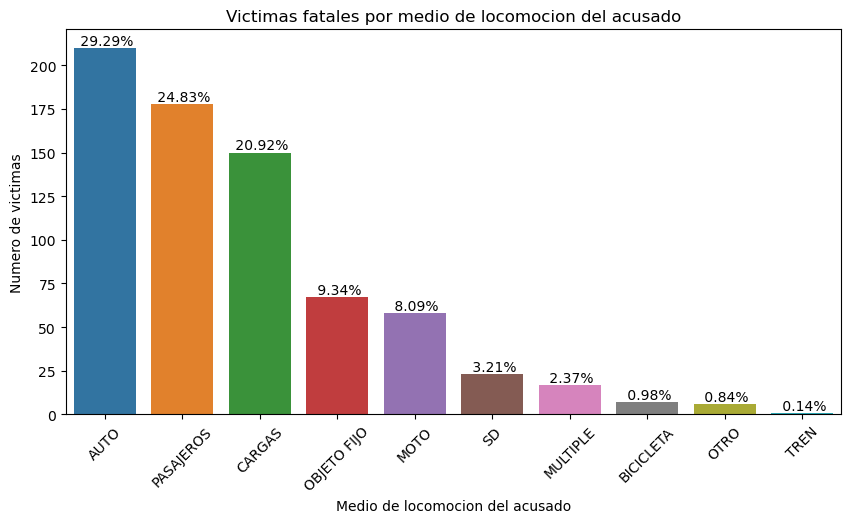

In [4]:
# Victimas totales por tipo de vehiculo del acusado
events_by_victim = homicidio_hecho.groupby('acusado')['num_victimas'].sum().reset_index(name = 'num_victimas')
events_by_victim.sort_values(by = 'num_victimas', axis = 0, ascending = False, inplace = True)
events_by_victim['porcentaje'] = round(100 * events_by_victim['num_victimas'] / victimas_totales, 2)

plt.figure(figsize = (10,5))
ax = sns.barplot(x = 'acusado', y = 'num_victimas', data = events_by_victim, 
                 order = events_by_victim.sort_values('num_victimas', ascending = False).acusado)
labels = [f' {events_by_victim.iloc[i, 2]}%' for i, v in enumerate(ax.containers[0])]
ax.bar_label(ax.containers[0], labels = labels)
for item in ax.get_xticklabels(): item.set_rotation(45)
plt.title('Victimas fatales por medio de locomocion del acusado')
plt.xlabel('Medio de locomocion del acusado')
plt.ylabel('Numero de victimas')

plt.show()

# obvservandose que los tres principales medios de locomocion del acusado son auto, 
# son medios de transporte de pasajeros y vehiculos de carga

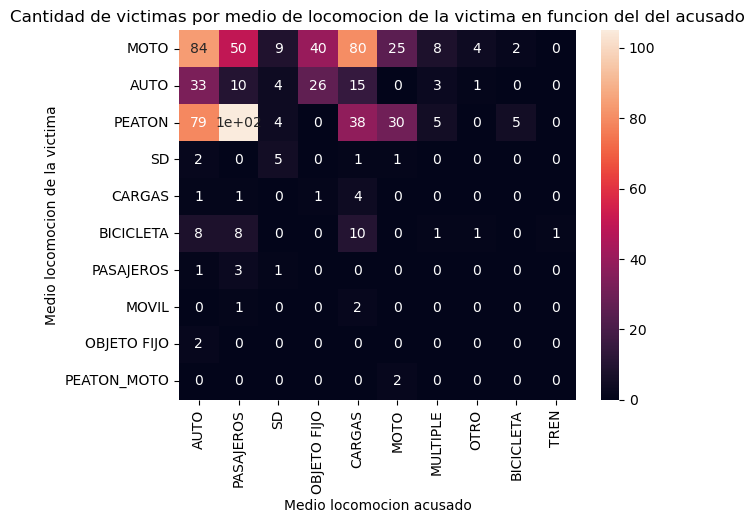

In [5]:
# correlacion entre medios de locomocion victima - acusado
acusado_lst = list(homicidio_hecho.acusado.unique())
victima_lst = list(homicidio_hecho.victima.unique())

def heatmap_acusado_vict(df):
    acusado_vict_mat = pd.DataFrame(columns = acusado_lst, index = victima_lst)
    acusado_vict_mat = acusado_vict_mat.fillna(0)
    for i in victima_lst:
        condition = df['victima'] == i
        temp2_df = df.loc[condition, :]
        row_dict = dict(temp2_df.groupby('acusado')['num_victimas'].sum())
        
        acusado_vict_mat.loc[i] = row_dict
    acusado_vict_mat = acusado_vict_mat.fillna(0)
    acusado_vict_mat = acusado_vict_mat.astype('int32')
    heatmap = sns.heatmap(acusado_vict_mat, annot = True).set_title('Acusados - victima')
    return heatmap

heatmap_acusado_vict(homicidio_hecho)
plt.title('Cantidad de victimas por medio de locomocion de la victima en funcion del del acusado')
plt.xlabel('Medio locomocion acusado')
plt.ylabel('Medio locomocion de la victima')
plt.show()

# en la siguiente figura se muestra cuantas victimas han producido cada par acusado - victima
# caracterizados por sus respectivos metodos de locomocion. En ella se puede comprobar 
# las conclusiones otorgadas por las graficas anteriores pero con mayor detalle dado que la
# mayor cantidad de victimas se producen en un conjunto reducido del par (acusado, victima)

**Analisis temporal de eventos**

In [6]:
# creacion de columna AAAA-S (año - semestre)
homicidio_hecho['fecha'] = homicidio_hecho.fecha.astype('datetime64[ns]')
homicidio_hecho['semestre'] = homicidio_hecho.fecha.dt.year.astype(str) + '-' + np.where(homicidio_hecho.fecha.dt.quarter.gt(2), 2, 1).astype(str)

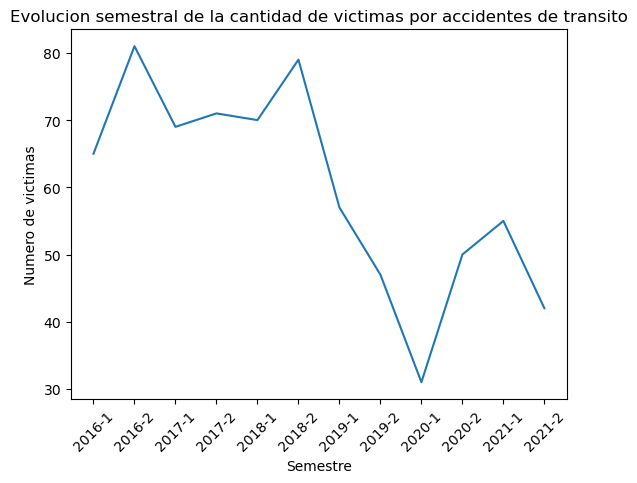

In [7]:
events_by_day = homicidio_hecho.groupby('semestre')['num_victimas'].sum().reset_index(name = 'num_victimas')

ax = sns.lineplot(x = 'semestre', y = 'num_victimas', data = events_by_day)
plt.title('Evolucion semestral de la cantidad de victimas por accidentes de transito')
plt.xlabel('Semestre')
plt.ylabel('Numero de victimas')
for item in ax.get_xticklabels(): item.set_rotation(45)
plt.show()

# donde se observa una constante y notable disminucion del numero de victimas a partir del segundo semestre
# del 2018 hasta alcanzar un minimo en el primer semestre del 2020 para luego volver aumentar aunque
# a valores no tan elevados como los anteriores.

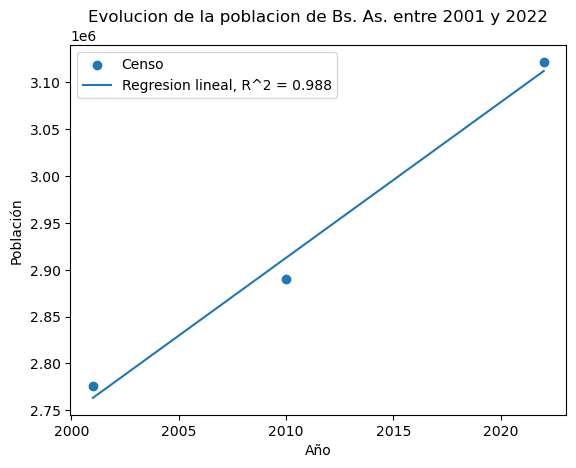

In [8]:
# La forma estandar de presentar datos referidos al conjunto poblacion de forma que sea independiente
# de las variaciones en el tiempo de la misma o para comparar entre distintos districtos es normalizar los
# datos a la cantidad total de poblacion del districto (e.g. eventos por cada 100.000 habitantes)

# segun datos del Instituto de Estadisticas y Censos de Argentina https://portalgeoestadistico.indec.gob.ar
# la evolucion de la poblacion de la ciudad de buenos aires en los ultimos 3 censos es:
censo_anios = np.array([2001, 2010, 2022]).reshape((-1, 1))
poblacion_CABA = np.array([2776138, 2890151, 3121707])

# los datos de accidentes tratados en este trabajo se encuentran enmarcados en el periodo 2016-2021 por lo que
# se encuentran entre los censos del 2010 y 2022 pero sin incluirlos. Para establecer un valor poblacional en los
# momentos estudiados se realiza una regresion lineal de los datos de los ultimos 3 censos y el valor incognita es
# extraido por el valor que tome la funcion de ajuste pob(t) = a + b * t (a y b coeficientes de la regresion)
modelo = LinearRegression()
modelo.fit(censo_anios, poblacion_CABA)
modelo.score(censo_anios, poblacion_CABA)

regresion_coef_a = modelo.intercept_
regresion_coef_b = modelo.coef_[0]

poblacion_CABA_regresion = regresion_coef_a + regresion_coef_b * censo_anios

plt.scatter(censo_anios, poblacion_CABA)
plt.plot(censo_anios, poblacion_CABA_regresion)
plt.title('Evolucion de la poblacion de Bs. As. entre 2001 y 2022')
plt.xlabel('Año')
plt.ylabel('Población')
plt.legend(['Censo', 'Regresion lineal, R^2 = {}'.format(modelo.score(censo_anios, poblacion_CABA).round(3))])
plt.show()

In [9]:
def poblacion_estimada(anio_inicial:int, anio_final:int, segmentacion:int):
    """
    Funcion para calcular la poblacion estimada de la ciudad de bs as entre los años 'anio_inicial' y 'anio_final'
    con una cantindad de puntos determinada por 'segmentacion' \n
    'segmentacion' = 1 la frecuencia del calculo es anual \n
    'segmentacion' = 2 semestral \n
    'segmentacion' = 4 trimestral \n
    'segmentacion' = 12 mensual \n
    El valor calculado corresponde al punto medio (en escala temporal) del periodo calculado
    (e.g. si se calcula la poblacion para el 1er semestre de 2018, entonces el valor reportado es el de marzo de ese año)
    """
    temp_lst = np.linspace(anio_inicial, anio_final, (anio_final-anio_inicial) * 2 * segmentacion, endpoint = False)
    temp2_lst = temp_lst[1::2]
    resultado_lst = []
    for i in temp2_lst:
        resultado_lst.append(regresion_coef_a + regresion_coef_b * i)
    return resultado_lst

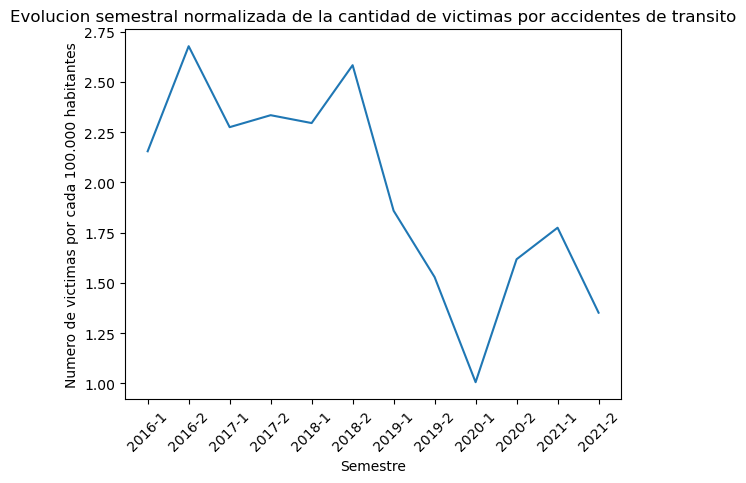

In [10]:
# entonces, rehaciendo la evolucion temporal anterior pero normalizando a la cantidad de poblacion
events_by_day_norm = homicidio_hecho.groupby('semestre')['num_victimas'].sum().reset_index(name = 'num_victimas')
events_by_day_norm['poblacion_est_100k'] = poblacion_estimada(2016, 2022, 2)
events_by_day_norm['poblacion_est_100k'] /= 100000
events_by_day_norm['num_victimas_norm'] = events_by_day_norm['num_victimas'] / events_by_day_norm['poblacion_est_100k']

ax = sns.lineplot(x = 'semestre', y = 'num_victimas_norm', data = events_by_day_norm)
plt.title('Evolucion semestral normalizada de la cantidad de victimas por accidentes de transito')
plt.xlabel('Semestre')
plt.ylabel('Numero de victimas por cada 100.000 habitantes')
for item in ax.get_xticklabels(): item.set_rotation(45)
plt.show()

# como era de esperarse, las conclusiones y tendencias comentadas anteriormente, 
# al analizar los datos sin normalizar solo modifica las diferencias levemente 
# dado que la evolucion de la poblacion no rompe la tendencia

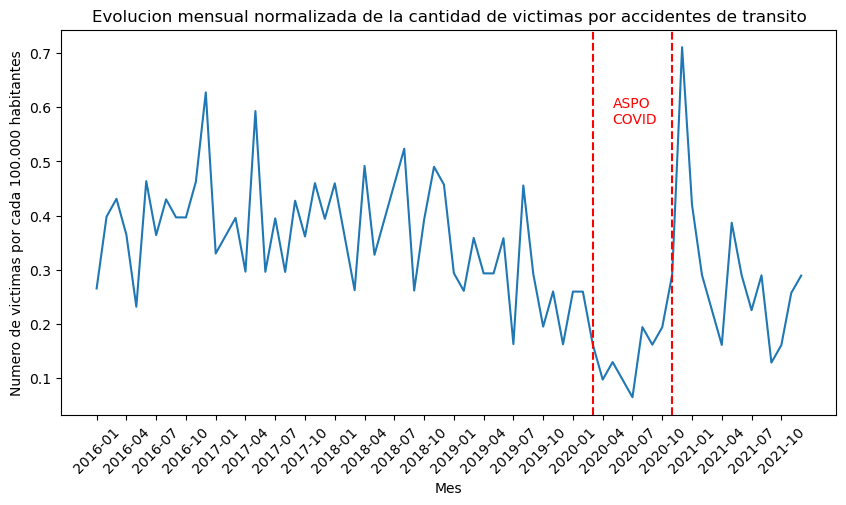

In [11]:
# sin embargo, este comportamiento en la evolucion de la serie temporal no puede ser analizada en forma tan
# simple debido la aparicion de un evento disruptivo en el comportamiento poblacional dentro del rango temporal analizado
# La epidemia global de COVID-19 tuvo sus primeros efectos en Argentina en los primeros meses del 2020.
# Entre marzo y noviembre del 2020 la ciudad de bs as estuvo bajo el Aislamiento Social Preventivo Obligatorio (ASPO)
# afectando significativamente todos los aspectos de la vida social de sus habitantes, la circulacion en vias publicas entre ellos
# entonces es de esperar que la cantidad de accidentes sea considerablemente menor en este espacio temporal pero solo por el hecho
# de que hay menos circulacion de personas y no por el hecho de la efectividad de una posible medida publica.

# Al observar el valor obtenido en el segundo semestre del 2020 se puede determinar que la mayoria de los accidentes
# fatales ocurridos en este semestre ocurrieron en el mes de diciembre, justamente cuando fue levantada la
# medida de aislamiento obligatorio y que no solo este aumento se produce en este mes sino que se produce el record
# de victimas fatales mensuales en todo el periodo temporal con que se cuenta datos

homicidio_hecho['AAAA-MM'] = homicidio_hecho['fecha'].astype('str').str[:-3]

events_by_day_norm = homicidio_hecho.groupby('AAAA-MM')['num_victimas'].sum().reset_index(name = 'num_victimas')
events_by_day_norm['poblacion_est_100k'] = poblacion_estimada(2016, 2022, 12)
events_by_day_norm['poblacion_est_100k'] /= 100000
events_by_day_norm['num_victimas_norm'] = events_by_day_norm['num_victimas'] / events_by_day_norm['poblacion_est_100k']

plt.figure(figsize = (10,5))
ax = sns.lineplot(x = 'AAAA-MM', y = 'num_victimas_norm', data = events_by_day_norm)
plt.title('Evolucion mensual normalizada de la cantidad de victimas por accidentes de transito')
plt.xlabel('Mes')
plt.ylabel('Numero de victimas por cada 100.000 habitantes')
plt.xticks(events_by_day_norm['AAAA-MM'][::3],events_by_day_norm['AAAA-MM'][::3], rotation='vertical')
for item in ax.get_xticklabels(): item.set_rotation(45)

plt.axvline(x = '2020-03', color = 'red', linestyle = '--')
plt.axvline(x = '2020-11', color = 'red', linestyle = '--')
plt.text('2020-05', 0.6, 'ASPO', color = 'red')
plt.text('2020-05', 0.57, 'COVID', color = 'red')

plt.show()

In [ ]:
# Se exploró la idea de normalizar respecto al flujo vehicular de la ciudad tomando en cuenta el dataset en
# https://data.buenosaires.gob.ar/dataset/flujo-vehicular-anillo-digital
# donde se encuentra el flujo vehicular medido en ciertos cruces de calles de la ciudad en funcion del dia y 
# de la hora del dia. De esta forma se podria normalizar los accidentes viales a la cantidad de vehiculos en
# circulacion y, por lo tanto, evitar el problema de cambios en la rutina de los ciudadanos. Ademas el 
# dataset cuenta con la informacion geografica de donde estan emplazados los sensores por lo que se podria
# hacer un analisis discriminado por Comuna (y comparar comuna a comuna)
# Sin embargo, los datos disponibles en este dataset comienzan a partir de febrero del 2020 lo cual no permite 
# independizar del efecto de ASPO.
# Como comentario, una normalizacion victimas en cada comuna respecto a la cantidad de habitantes de dicha
# Comuna no se considera correcto debido a la naturaleza movil del problema, es decir, un accidente puede haber
# ocurrido en la Comuna A y la victima ser de la Comuna F (o ni siquiera de la Ciudad de Bs. As.)

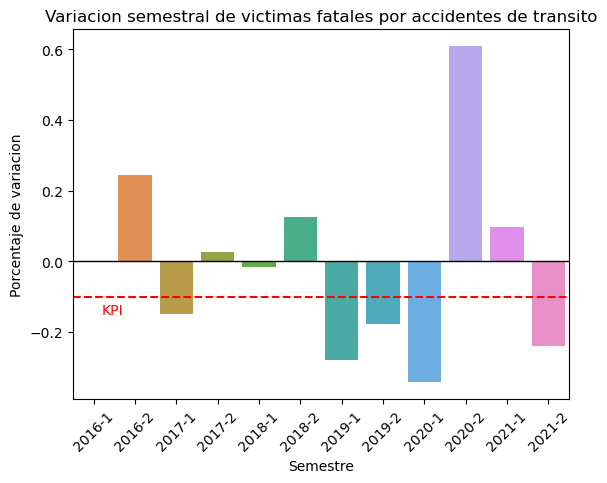

In [190]:
# En vista del primer KPI, vamos a calcular la variacion semestral de victimas en siniestros viales
# y cuando se produce una disminucion mayor al 10% intersemestral
events_by_day_norm = homicidio_hecho.groupby('semestre')['num_victimas'].sum().reset_index(name = 'num_victimas')
events_by_day_norm['poblacion_est_100k'] = poblacion_estimada(2016, 2022, 2)
events_by_day_norm['poblacion_est_100k'] /= 100000
events_by_day_norm['num_victimas_norm'] = events_by_day_norm['num_victimas'] / events_by_day_norm['poblacion_est_100k']

def variacion(lista:list):
    temp_lst = []
    #for i in range(1,len(list(events_by_day_norm['num_victimas_norm']))):
    for i in range(1,len(lista)):
        porcentaje_variacion = (lista[i] / lista[i - 1]) - 1
        temp_lst.append(porcentaje_variacion)   
    return temp_lst

# events_by_day_norm['variacion_porcentual'] = np.NaN
variacion_porcent_lst = variacion(list(events_by_day_norm['num_victimas_norm']))
variacion_porcent_lst.insert(0, np.nan)

events_by_day_norm['variacion_porcentual'] = variacion_porcent_lst

ax = sns.barplot(x = 'semestre', y = 'variacion_porcentual', data = events_by_day_norm)
plt.title('Variacion semestral de victimas fatales por accidentes de transito')
plt.xlabel('Semestre')
plt.ylabel('Porcentaje de variacion')
for item in ax.get_xticklabels(): item.set_rotation(45)

plt.axhline(y = 0, color = 'black', linewidth = 1)
plt.axhline(y = -0.1, color = 'red', linestyle = '--')
plt.text(.2, -0.15, 'KPI', color = 'red')
plt.show()


In [85]:
# donde se observa claramente en cuales semestres el objetivo planteado en el KPI es cumplido y en cuales no
condition = events_by_day_norm['variacion_porcentual'] <= -0.1
events_by_day_norm.loc[condition, ['semestre', 'variacion_porcentual']]

# donde se remarca lo anteriormente dicho, debido a la situacion impuesta por las medidas sanitarias,
# el semestre 2020-1 no deberia ser contado como un exito en el presente KPI

,semestre,variacion_porcentual
2,2017-1,-0.150480
6,2019-1,-0.280435
7,2019-2,-0.177666
8,2020-1,-0.342202
11,2021-2,-0.238404


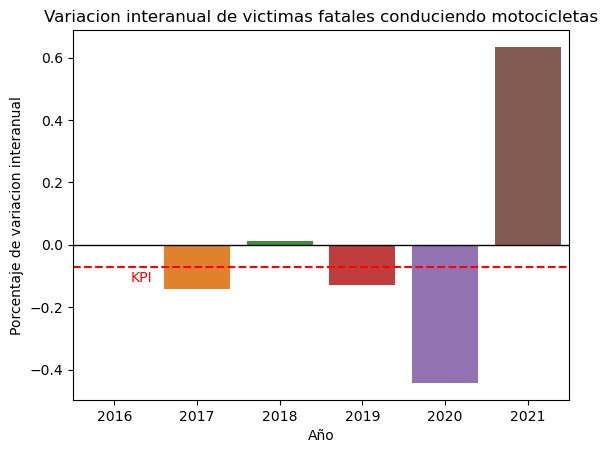

In [199]:
# Como fue visto durante el analisis por tipo de vehiculo, el medio de locomocion de la victima con mayor
# incidencia en el numero de fatalidades es la moto por lo que es interesante hacer un analisis especifico 
# sobre la evolucion del numero de victimas cuando conducen este tipo de vehiculos.
# Esto conduce al segundo KPI a seguir en el presente trabajo: calcular la variacion interanual de victimas 
# en siniestros viales que conducian motos y cuando se produce una disminucion mayor al 7% interanual
condition = homicidio_hecho['victima'] == 'MOTO'
events_by_year_moto_norm = homicidio_hecho.loc[condition]
events_by_year_moto_norm = events_by_year_moto_norm.groupby('anio')['num_victimas'].sum().reset_index(name = 'num_victimas')
events_by_year_moto_norm['poblacion_est_100k'] = poblacion_estimada(2016, 2022, 1)
events_by_year_moto_norm['poblacion_est_100k'] /= 100000
events_by_year_moto_norm['num_victimas_norm'] = events_by_year_moto_norm['num_victimas'] / events_by_year_moto_norm['poblacion_est_100k']


variacion_porcent_lst = variacion(list(events_by_year_moto_norm['num_victimas_norm']))
variacion_porcent_lst.insert(0, np.nan)
events_by_year_moto_norm
events_by_year_moto_norm['variacion_porcentual'] = variacion_porcent_lst

ax = sns.barplot(x = 'anio', y = 'variacion_porcentual', data = events_by_year_moto_norm)
plt.title('Variacion interanual de victimas fatales conduciendo motocicletas')
plt.xlabel('Año')
plt.ylabel('Porcentaje de variacion interanual')

plt.axhline(y = 0, color = 'black', linewidth = 1)
plt.axhline(y = -0.07, color = 'red', linestyle = '--')
plt.text(.2, -0.12, 'KPI', color = 'red')
plt.show()

In [203]:
# donde se observa claramente en cuales añps el objetivo planteado en el KPI es cumplido y en cuales no
condition = events_by_year_moto_norm['variacion_porcentual'] <= -0.07
events_by_year_moto_norm.loc[condition, ['anio', 'variacion_porcentual']]

# donde se remarca lo anteriormente dicho, debido a la situacion impuesta por las medidas sanitarias,
# el año 2020 no deberia ser contado como un exito en el presente KPI

,anio,variacion_porcentual
1,2017,-0.143173
3,2019,-0.127552
4,2020,-0.443013


media de fallecidos por dia de semana:  102.0
desviacion estandar fallecidos por semana:  4.0


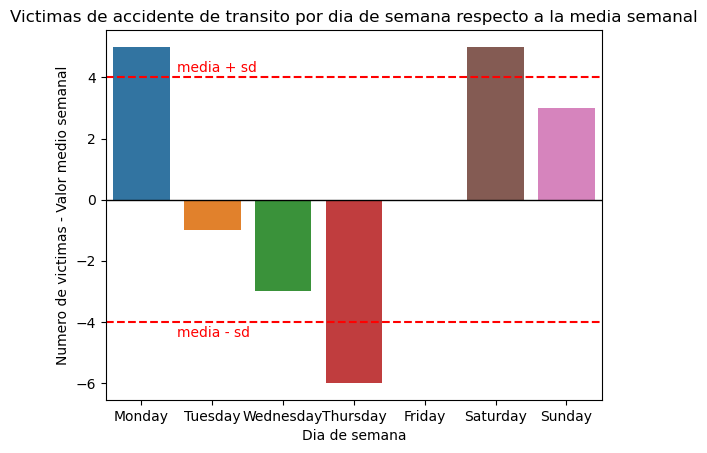

In [40]:
# ahora pasemos al estudio temporal en el marco de los dias de la semana
events_by_day = homicidio_hecho.groupby('dia_semana')['num_victimas'].sum().reset_index(name = 'num_victimas')
week_day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

print("media de fallecidos por dia de semana: ", round(events_by_day.num_victimas.mean(), 0))
print("desviacion estandar fallecidos por semana: ", round(events_by_day.num_victimas.std(), 0))

events_by_day['num_victimas_media'] = events_by_day['num_victimas'] - round(events_by_day.num_victimas.mean(), 0)
sns.barplot(x = 'dia_semana', y = 'num_victimas_media', data = events_by_day, order = week_day_order)
plt.title('Victimas de accidente de transito por dia de semana respecto a la media semanal')
plt.xlabel('Dia de semana')
plt.ylabel('Numero de victimas - Valor medio semanal')

plt.axhline(y = 0, color = 'black', linewidth = 1)
plt.axhline(y = -round(events_by_day.num_victimas.std(), 0), color = 'red', linestyle = '--')
plt.text(.5, -4.5, 'media - sd', color = 'red')
plt.axhline(y = round(events_by_day.num_victimas.std(), 0), color = 'red', linestyle = '--')
plt.text(.5, 4.2, 'media + sd', color = 'red')

plt.show()

# donde se puede apreciar que, si consideramos a 1 desviacion estandar como parametro de fluctuacion
# estadistica, lunes y sabados se producen significativamente mas accidentes fatales que la media y,
# por el contrario, solo los jueves se producen signifiativmente menos

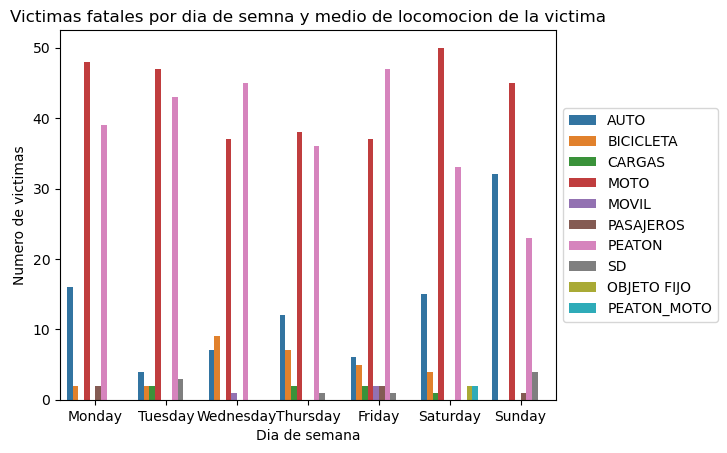

In [45]:
# desglosando la incidencia del metodo de locomocion de la victima en el analisis semanal
events_by_day = homicidio_hecho.groupby(['dia_semana', 'victima'])['num_victimas'].sum().reset_index(name = 'num_victimas')
ax = sns.barplot(x = 'dia_semana', y = 'num_victimas', data = events_by_day, order = week_day_order, hue = 'victima')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Victimas fatales por dia de semana y medio de locomocion de la victima')
plt.xlabel('Dia de semana')
plt.ylabel('Numero de victimas')
plt.show()

# De los 3 medios de locomocion que mas inciden (moto, peaton, auto), se puede observar que 
# 5 de los 7 dias de la semana el mas alto indice de victimas es el relacionado
# con motociclistas y en los 2 restantes con peatones. Es notable la superioridad de casos de motociclistas
# durante el fin de semana frente al resto de las categorias y el aumento de victimas en auto durante
# el domingo (duplicando la media semanal para victimas en auto)

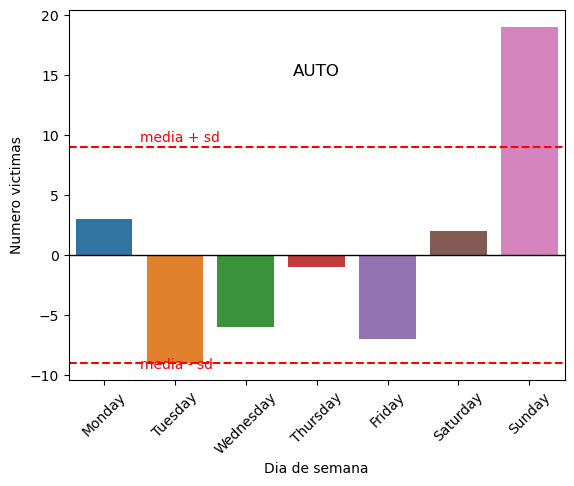

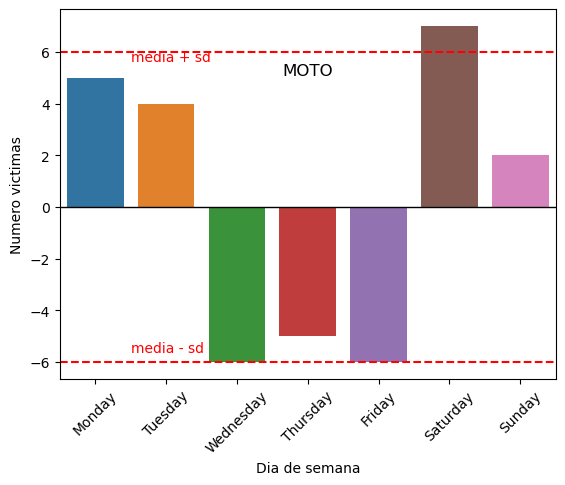

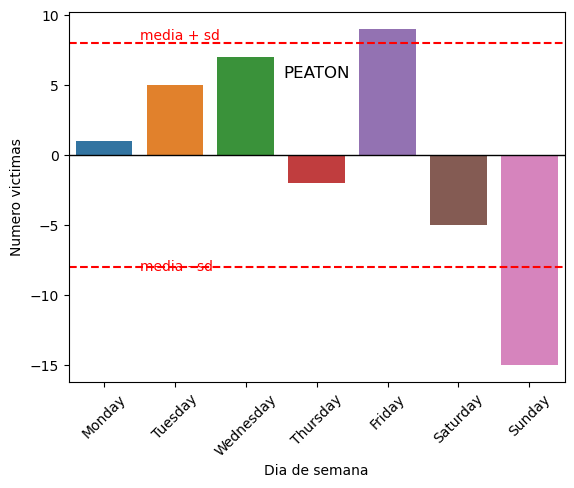

In [129]:
# repitiendo el analisis anterior pero ahora discriminado por medio de locomocion de la victima
# (los 3 medios con mas cantidad de vicitimas)
events_by_day = homicidio_hecho.groupby(['dia_semana', 'victima'])['num_victimas'].sum().reset_index(name = 'num_victimas')

temp_graph_lst = ['AUTO', 'MOTO', 'PEATON']

for i in range(3):
    condition = events_by_day['victima'] == temp_graph_lst[i]
    events_by_day_temp = events_by_day[condition].copy()

    diferencia = events_by_day_temp['num_victimas'] - round(events_by_day_temp['num_victimas'].mean(), 0)
    #events_by_day_temp['num_victimas_media'] = events_by_day_temp['num_victimas'] - round(events_by_day_temp.num_victimas.mean(), 0)
    events_by_day_temp['num_victimas_media'] = diferencia

    ax = sns.barplot(x = 'dia_semana', y = 'num_victimas_media', data = events_by_day_temp, order = week_day_order)
    ax.set_xlabel('Dia de semana')
    ax.set_ylabel('Numero victimas - valor medio semanal')
    ax.set_title(temp_graph_lst[i], x = 0.5, y = 0.8)
    ax.axhline(y = 0, color = 'black', linewidth = 1)
    ax.axhline(y = -round(events_by_day_temp.num_victimas_media.std(), 0), color = 'red', linestyle = '--')
    ax.text(.5, -events_by_day_temp.num_victimas_media.std(), 'media - sd', color = 'red')
    ax.axhline(y = round(events_by_day_temp.num_victimas_media.std(), 0), color = 'red', linestyle = '--')
    ax.text(.5, events_by_day_temp.num_victimas_media.std(), 'media + sd', color = 'red')
    for item in ax.get_xticklabels(): item.set_rotation(45)
    plt.show()

# donde se puede observar que la cantidad de victimas peatonales es relativamente constante durante los dias
# de semana pero que disminuyen considerable durante los fines de semana (los domingos considerablemente) y
# practimante sucede lo opuesto para las victimas en auto donde la gran mayoria de las victimas son ocurren
# durante los domingos (este valor explica la alta sd obtenida y un analisis mas certero implicaria adoptar
# como outliers los domingos para AUTO y PEATON). Por otro lado, a pesar de tener la mayor incidencia en los fallecidos totales,
# la distribucion de victimas motociclistas es mas uniforme a lo largo de la semana, donde practicamente el unico
# dia que se destaca es el sabado con un numero de victimas levemente por encima 1 desviacion estandar 
# de la media semanal.

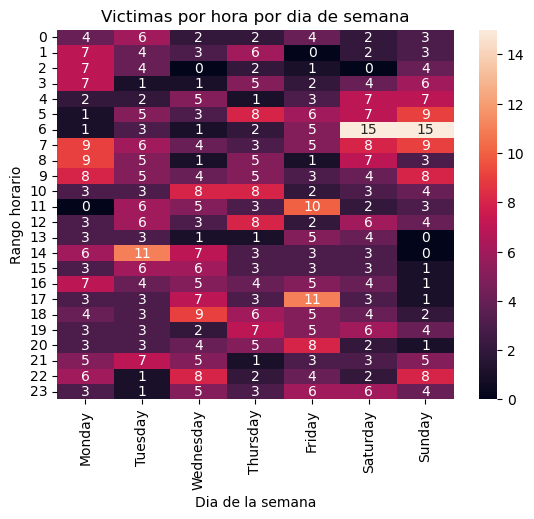

In [149]:
# distribuicion de eventos por hora en la semana
hora_lst = list(homicidio_hecho.hora_rango.unique())
hora_lst.sort()
dia_semana_lst = week_day_order

def heatmap_hora_semana(df):
    hora_diasemana_mat = pd.DataFrame(columns = dia_semana_lst, index = hora_lst)
    hora_diasemana_mat = hora_diasemana_mat.fillna(0)
    for i in hora_lst:
        condition = df['hora_rango'] == i
        temp2_df = df.loc[condition, :]
        row_dict = dict(temp2_df.groupby('dia_semana')['num_victimas'].sum())
        
        hora_diasemana_mat.loc[i] = row_dict
    hora_diasemana_mat = hora_diasemana_mat.fillna(0)
    hora_diasemana_mat = hora_diasemana_mat.astype('int32')
    heatmap = sns.heatmap(hora_diasemana_mat, annot = True).set_title('Victimas por hora por dia de semana')
    return heatmap

heatmap_hora_semana(homicidio_hecho)
plt.xlabel('Dia de la semana')
plt.ylabel('Rango horario')
plt.show()

# en la siguiente matriz se muestra la distribucion horaria de los fallecimientos por accidentes viales segun
# el dia de la semana. Notablemente los valores maximos se alcanzan entre las 6 y 7am de sabados y domingo.
# Mas ampliamente, el rango entre las 3 y las 8am de esos dias presentan valores significativamente altos respecto
# a la media

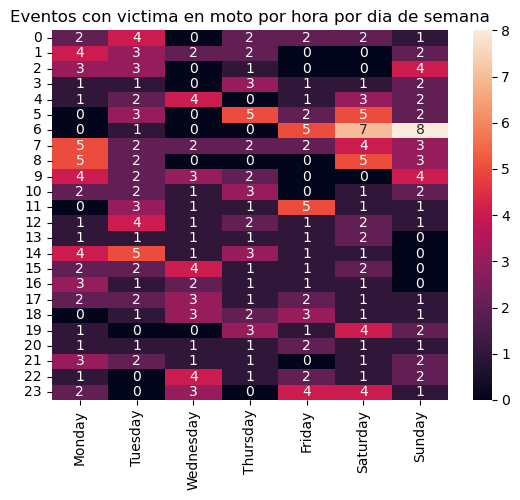

In [150]:
# si ahora filtramos solo aquellos en los que la victima se desplazaba en MOTO
condition_filter = homicidio_hecho['victima'] == 'MOTO'
filtered_df = homicidio_hecho.loc[condition_filter, :]

heatmap_hora_semana(filtered_df)
plt.title('Eventos con victima en moto por hora por dia de semana')
plt.xlabel('Dia de la semana')
plt.ylabel('Rango horario')
plt.show()

# se puede observar que aproximadamente la mitad de los fallecidos en la franja horaria previamente destacada, 
# entre las 3 y las 8am de sabado y domingo, son victimas que se desplazaban en motocicleta.

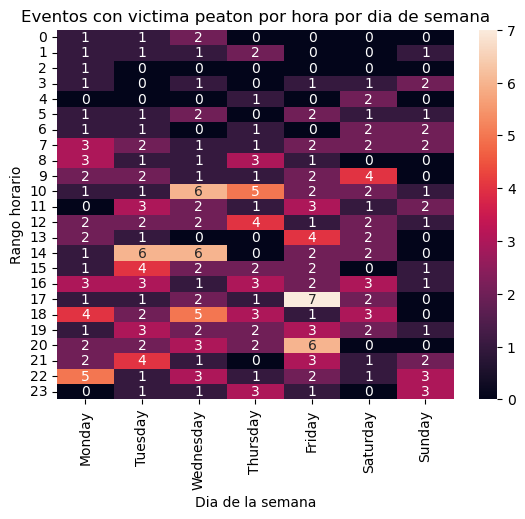

In [151]:
# si ahora filtramos solo aquellos en los que la victima son peatones
condition_filter = homicidio_hecho['victima'] == 'PEATON'
filtered_df = homicidio_hecho.loc[condition_filter, :]

heatmap_hora_semana(filtered_df)
plt.title('Eventos con victima peaton por hora por dia de semana')
plt.xlabel('Dia de la semana')
plt.ylabel('Rango horario')
plt.show()

# se observa que la mayor proporcion de victimas peatonales se encuentra distribuida durante las tardes de
# los dias de semana.

media de fallecidos por mes:  60.0
desviacion estandar fallecidos por mes:  9.0


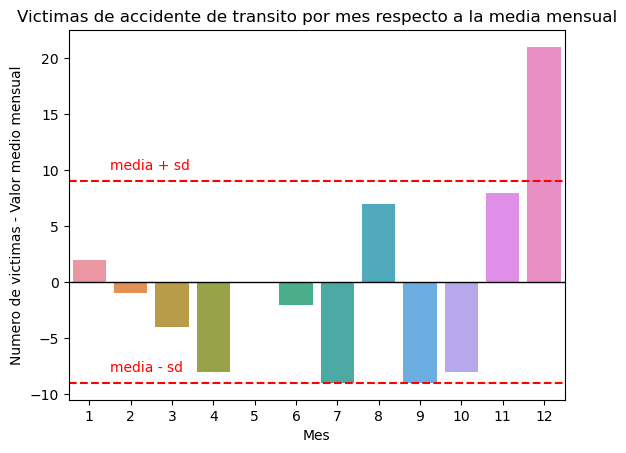

In [141]:
# ahora pasemos al estudio temporal en el marco mensual
events_by_month = homicidio_hecho.groupby('mes')['num_victimas'].sum().reset_index(name = 'num_victimas')
# week_day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

print("media de fallecidos por mes: ", round(events_by_month.num_victimas.mean(), 0))
print("desviacion estandar fallecidos por mes: ", round(events_by_month.num_victimas.std(), 0))

events_by_month['num_victimas_media'] = events_by_month['num_victimas'] - round(events_by_month.num_victimas.mean(), 0)
ax = sns.barplot(x = 'mes', y = 'num_victimas_media', data = events_by_month)
plt.title('Victimas de accidente de transito por mes respecto a la media mensual')
plt.xlabel('Mes')
plt.ylabel('Numero de victimas - Valor medio mensual')

plt.axhline(y = 0, color = 'black', linewidth = 1)
plt.axhline(y = -round(events_by_month.num_victimas.std(), 0), color = 'red', linestyle = '--')
plt.text(.5, -8, 'media - sd', color = 'red')
plt.axhline(y = round(events_by_month.num_victimas.std(), 0), color = 'red', linestyle = '--')
plt.text(.5, 10, 'media + sd', color = 'red')

plt.show()

# donde se observa que la distribucion mensual de fallecimientos por accidentes viales es uniforme mes a mes
# con la notable excepcion de diciembre que presenta un numero de victimas que supera las 2 desviaciones estandar
# de la media mensual.

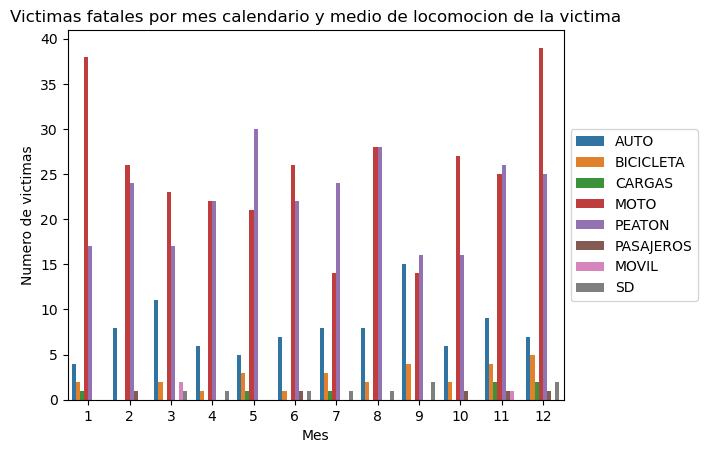

In [134]:
# discrimando por medio de locomocion de la victima
events_by_month = homicidio_vict.groupby(['mes', 'victima'])['id'].count().reset_index(name = 'num_victimas')
ax = sns.barplot(x = 'mes', y = 'num_victimas', data = events_by_month, hue = 'victima')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Victimas fatales por mes calendario y medio de locomocion de la victima')
plt.xlabel('Mes')
plt.ylabel('Numero de victimas')
plt.show()

# se observa que MOTO es el medio predominante en 8 meses, siendo las victimas peatonales predominante en los
# restantes 4 meses. Las victimas en AUTO conforman el tercer grupo en importancia sobre el total de fallecidos
# Ademas se puede destacar la alta incidencia de las victimas en moto durante los meses de enero y diciembre
# respecto a los otros medios de locomocion, asi mismo para las victimas peatonales durante los meses de mayo y julio

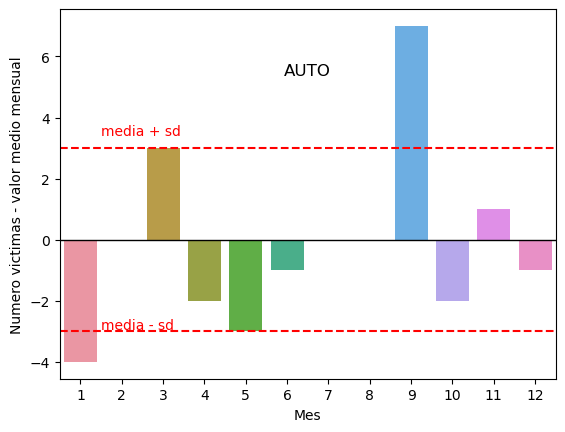

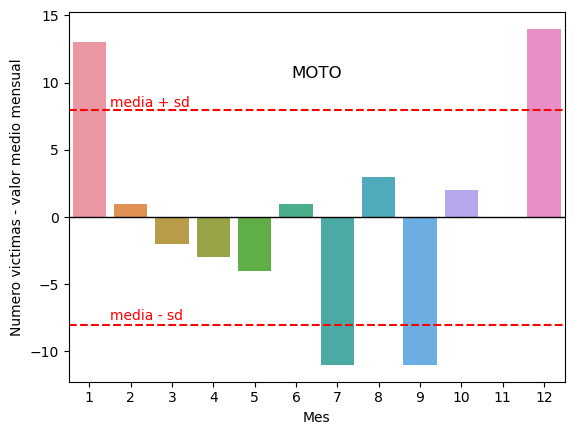

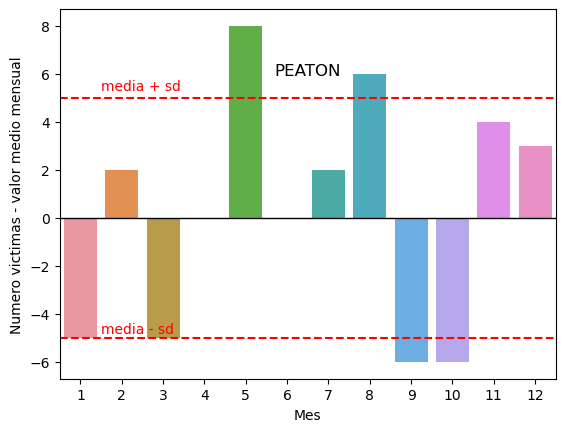

In [146]:
# centrando la atencion en la distribucion mensual de fallecidos para los 3 medios de locomocion de la victima con
# mayor incidencia en el total mensual de fallecimientos
events_by_month = homicidio_vict.groupby(['mes', 'victima'])['id'].count().reset_index(name = 'num_victimas')

temp_graph_lst = ['AUTO', 'MOTO', 'PEATON']

for i in range(3):
    condition = events_by_month['victima'] == temp_graph_lst[i]
    events_by_month_temp = events_by_month[condition].copy()

    diferencia = events_by_month_temp['num_victimas'] - round(events_by_month_temp['num_victimas'].mean(), 0)
    events_by_month_temp['num_victimas_media'] = diferencia

    ax = sns.barplot(x = 'mes', y = 'num_victimas_media', data = events_by_month_temp)
    ax.set_xlabel('Mes')
    ax.set_ylabel('Numero victimas - valor medio mensual')
    ax.set_title(temp_graph_lst[i], x = 0.5, y = 0.8)
    ax.axhline(y = 0, color = 'black', linewidth = 1)
    ax.axhline(y = -round(events_by_month_temp.num_victimas_media.std(), 0), color = 'red', linestyle = '--')
    ax.text(.5, -events_by_month_temp.num_victimas_media.std(), 'media - sd', color = 'red')
    ax.axhline(y = round(events_by_month_temp.num_victimas_media.std(), 0), color = 'red', linestyle = '--')
    ax.text(.5, .5 + events_by_month_temp.num_victimas_media.std(), 'media + sd', color = 'red')

    plt.show()

# se puede observar que la distribucion mensual de victimas en auto es relativamente uniforme a lo largo del año
# con excepcion de enero que presenta valores por debajo de 1 sd y particularmente septiembre con un valor
# de mas de 2 sd por encima de la media de victimas. Ahora, en los casos de motociclistas y peatones, se presentan
# 2 meses con valores que superan significativamente la media y 2 meses con valores significativamente menores

Analisis por edad

In [215]:
temp_df = homicidio_vict.merge(homicidio_hecho[['id', 'dia_semana', 'acusado', 'hora_rango', 'x', 'y', 'lugar', 'direc_norm', 'comuna']], how = 'left', on = 'id')


In [ ]:
temp_df.to_csv('./Datasets/vict-hecho.csv', sep = '|', encoding = 'utf-8')

In [172]:
temp2_df = temp_df.groupby(['edad_rango', 'victima'])['id'].count().reset_index(name = 'num_victimas')
edad_rango_lst = ['0-4', '5-12', '13-17', '18-29', '30-59', '60 o mas']
temp2_df['edad_rango'] = temp2_df['edad_rango'].astype('category')

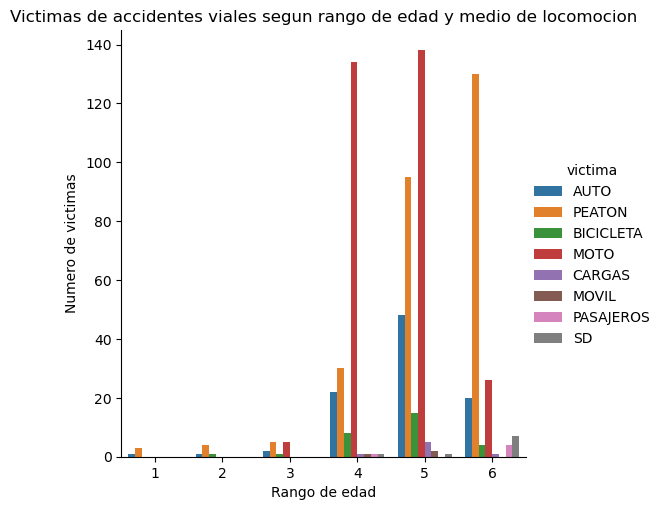

In [178]:
# Si analizamos la incidencia de accidentes fatales por rango de edad y tipo de locomocion de la victima
g = sns.catplot(x='edad_rango', y='num_victimas', hue='victima', data = temp2_df, kind = 'bar')
# plt.xticks(temp2_df.edad_rango, edad_rango_lst)
plt.title('Victimas de accidentes viales segun rango de edad y medio de locomocion')
plt.xlabel('Rango de edad')
plt.ylabel('Numero de victimas')
plt.show()

# se puede observar que las victimas que desplazaban en moto son significativemnte altas entre edades de 
# 18 y 29 años (rango 4) y entre 30 y 59 años (rango 5) mientras que la las victimas peatones ven incrementada
# su incidencia en el total a medida que aumenta la edad de la victima hasta hacerse la categoria predominante 
# entre los mayores de 60 años (rango 6).
# Notar que, debido a que los rangos elegidos son de distinto tamaño (rango 4 son 12 años, rango 5 son 30!), el
# alto valor registrado para motociclistas en el rango 4 es esperable que sea significativamente mas importante
# que el del rango 5 porque es esperable haya mas poblacion en el rango 5 que en el 4
# MEJORA: normalizar por poblacion en cada rango etario <<<---------------------

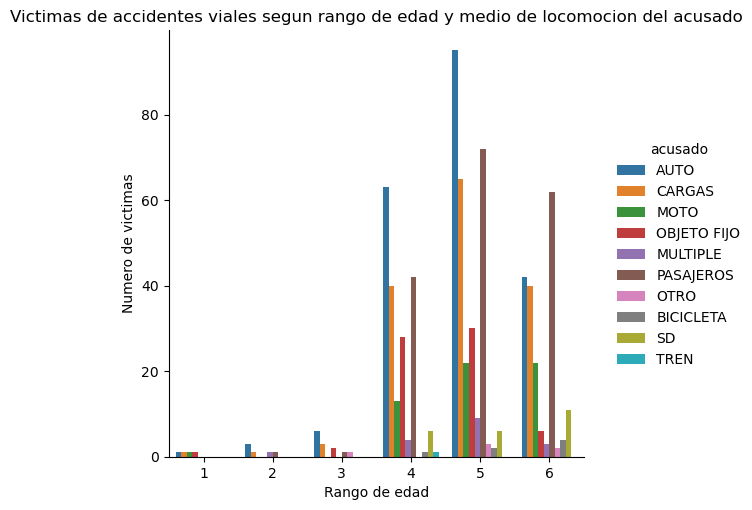

In [179]:
# repitiendo el analisis pero ahora viendo el medio de locomocion del acusado
temp2_acus_df = temp_df.groupby(['edad_rango', 'acusado'])['id'].count().reset_index(name = 'num_victimas')
g2 = sns.catplot(x = 'edad_rango', y = 'num_victimas', hue = 'acusado', 
                 data = temp2_acus_df, kind = 'bar', height = 5, aspect = 1)
plt.title('Victimas de accidentes viales segun rango de edad y medio de locomocion del acusado')
plt.xlabel('Rango de edad')
plt.ylabel('Numero de victimas')
plt.show()

# se observa que las victimas entre los 18 y 59 años son producidas mayoritariamente por autos y en segundo
# lugar los medios de pasajeros y de carga por igual. Para victimas mayores de 60 años, se invierte esta relacion
# y pasa a ser el medio predominante utilizado por el acusado el de pasajeros, seguidos por autos y cargas
# en igual proporcion

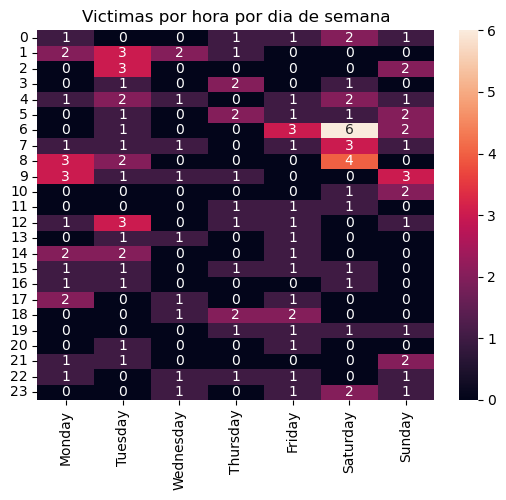

In [254]:
temp_edad_victima_df = temp_df.loc[(temp_df['edad_rango'] == 4) & (temp_df['victima'] == 'MOTO'), :]
temp_edad_victima_df = temp_edad_victima_df.groupby(['dia_semana', 'hora_rango'])['id'].count().reset_index(name = 'num_victimas')
heatmap_hora_semana(temp_edad_victima_df)
plt.show()

/tmp/ipykernel_467553/3957391449.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hora_diasemana_mat.loc[i] = row_dict
/tmp/ipykernel_467553/3957391449.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hora_diasemana_mat.loc[i] = row_dict
/tmp/ipykernel_467553/3957391449.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hora_diasemana_mat.loc[i] = row_dict


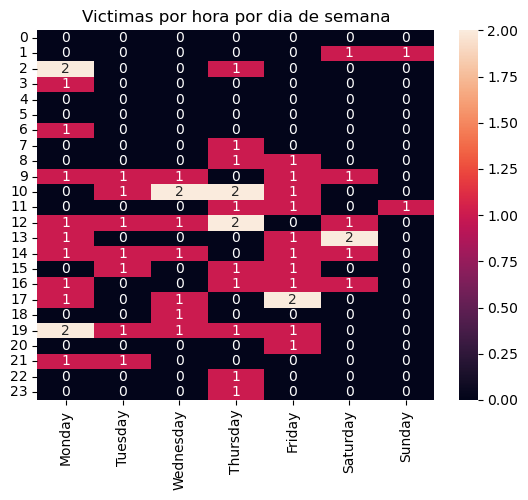

In [255]:
temp_edad_victima_df = temp_df.loc[(temp_df['edad_rango'] == 6) & (temp_df['acusado'] == 'PASAJEROS'), :]
temp_edad_victima_df = temp_edad_victima_df.groupby(['dia_semana', 'hora_rango'])['id'].count().reset_index(name = 'num_victimas')
heatmap_hora_semana(temp_edad_victima_df)
plt.show()

In [59]:
temp_df.to_csv('./Datasets/vict-hecho.csv', sep = "|", encoding = 'utf-8')

**Analisis por comuna**

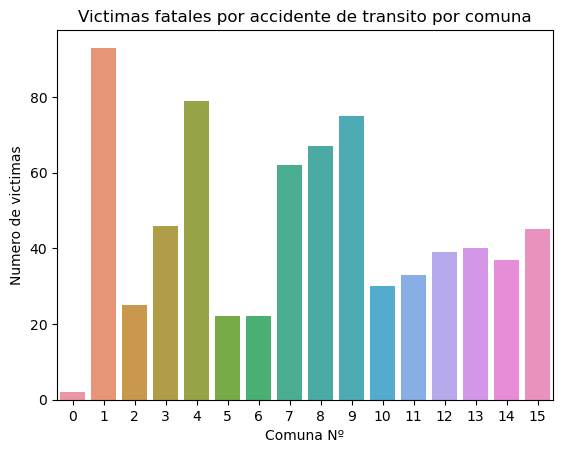

In [231]:
# si analizamos donde ocurrieron los accidentes con victimas fatales
temp4_df = temp_df.groupby(['comuna'])['id'].count().reset_index(name = 'num_victimas')
ax = sns.barplot(x = 'comuna', y = 'num_victimas', data = temp4_df)
plt.title('Victimas fatales por accidente de transito por comuna')
plt.xlabel('Comuna Nº')
plt.ylabel('Numero de victimas')
plt.show()
# observamos que la Comuna Nº1 es la que presenta el mayor numero de victimas fatales en su districto

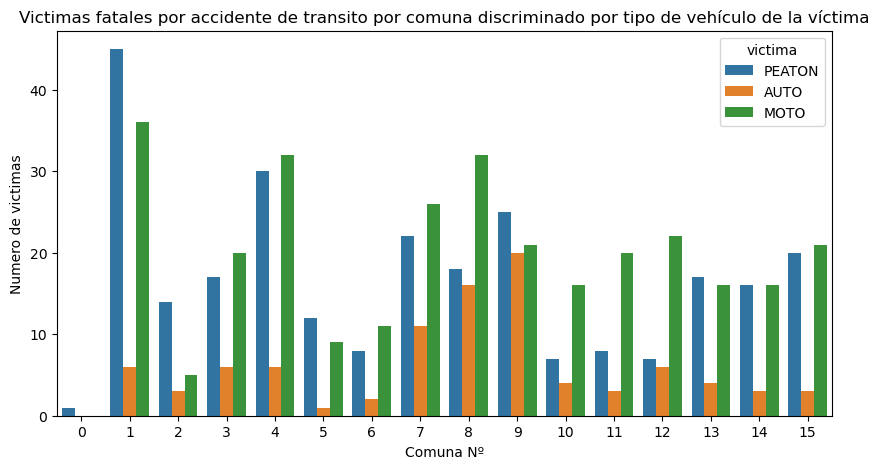

In [265]:
condition = temp_df['victima'].isin(['PEATON', 'MOTO', 'AUTO'])
temp4_df = temp_df.loc[condition]
temp4_df = temp4_df.groupby(['comuna', 'victima'])['id'].count().reset_index(name = 'num_victimas')

plt.figure(figsize = (10,5))
ax = sns.barplot(x = 'comuna', y = 'num_victimas', hue = 'victima', data = temp4_df)
plt.title('Victimas fatales por accidente de transito por comuna discriminado por tipo de vehículo de la víctima')
plt.xlabel('Comuna Nº')
plt.ylabel('Numero de victimas')
plt.show()

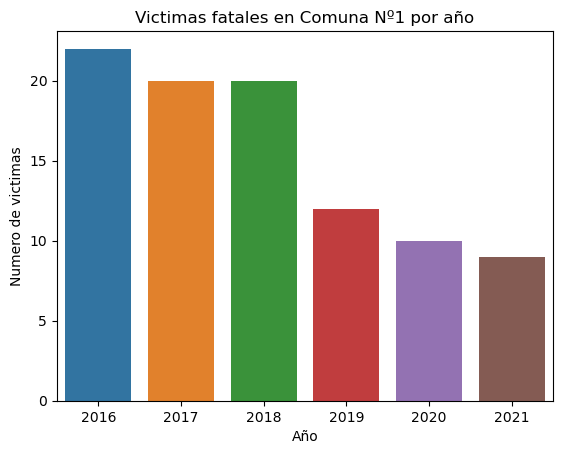

In [233]:
# entonces podemos establecer un objetivo de reduccion de accidentes fatales dentro de dicha comuna, 
# lo que deriva en el tercer KPI (propuesto): buscar la reduccion de victimas fatales en la comuna nª1
# un 10% interanual
condition = temp_df['comuna'] == 1
temp4_df = temp_df.loc[condition]
temp4_df = temp4_df.groupby('anio')['id'].count().reset_index(name = 'num_victimas')

ax = sns.barplot(x = 'anio', y = 'num_victimas', data = temp4_df)
plt.title('Victimas fatales en Comuna Nº1 por año')
plt.xlabel('Año')
plt.ylabel('Numero de victimas')
plt.show()

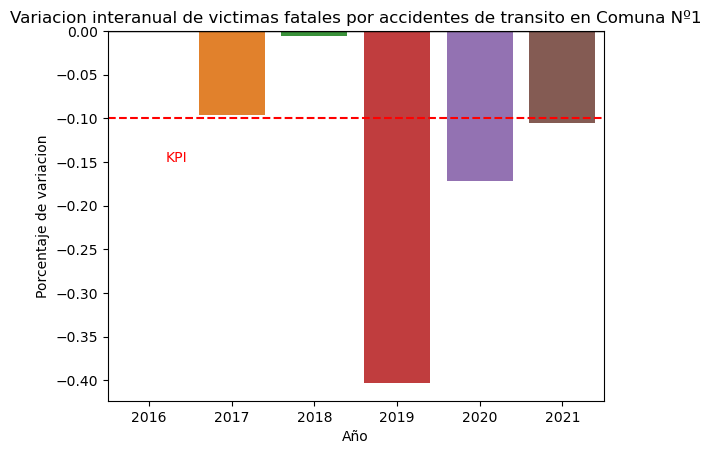

In [240]:
events_by_comuna_norm = temp4_df
events_by_comuna_norm['poblacion_est_100k'] = poblacion_estimada(2016, 2022, 1)
events_by_comuna_norm['poblacion_est_100k'] /= 100000
events_by_comuna_norm['num_victimas_norm'] = events_by_comuna_norm['num_victimas'] / events_by_comuna_norm['poblacion_est_100k']


variacion_porcent_lst = variacion(list(events_by_comuna_norm['num_victimas_norm']))
variacion_porcent_lst.insert(0, np.nan)

events_by_comuna_norm['variacion_porcentual'] = variacion_porcent_lst

ax = sns.barplot(x = 'anio', y = 'variacion_porcentual', data = events_by_comuna_norm)
plt.title('Variacion interanual de victimas fatales por accidentes de transito en Comuna Nº1')
plt.xlabel('Año')
plt.ylabel('Porcentaje de variacion')

plt.axhline(y = 0, color = 'black', linewidth = 1)
plt.axhline(y = -0.1, color = 'red', linestyle = '--')
plt.text(.2, -0.15, 'KPI', color = 'red')
plt.show()

# donde puede observarse que la cantidad de victimas fatales por accidentes de transito ha ido
# decayendo en forma continua año a año en la Comuna Nº1, sin embargo los años en los que se han 
# cumplido los objetivos del KPI propuesto han sido: 2019, 2020 y 2021 (con la salvedad de que 2020 
# ha sido dominado por el ASPO anteriormente analizado)

In [241]:
events_by_comuna_norm

,anio,num_victimas,poblacion_est_100k,num_victimas_norm,variacion_porcentual
0,2016,22,30.206827,0.728312,NaN
1,2017,20,30.372919,0.658481,-0.095880
2,2018,20,30.539011,0.654900,-0.005439
3,2019,12,30.705103,0.390815,-0.403246
4,2020,10,30.871196,0.323927,-0.171150
5,2021,9,31.037288,0.289974,-0.104816
